# Building weighted nearest neighbour model using text,color,brand and image

In [7]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [8]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [9]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [10]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [11]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [12]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [13]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [14]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [15]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

In [18]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

from IPython.display import display, Image, SVG, Math, YouTubeVideo

In [16]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

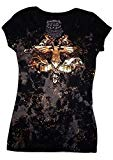

Product Title:  fifth degree womens gold foil graphic tees junior top short sleeve printed shirt  l 
Euclidean Distance from input image: 3.9598452252571934
Amazon Url: www.amzon.com/dp/B01NACPBG2


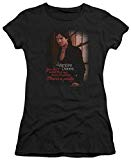

Product Title:  juniors vampire diaries  threes party juniors slim tshirt size l 
Euclidean Distance from input image: 15.642939289967494
Amazon Url: www.amzon.com/dp/B00IAAFXB8


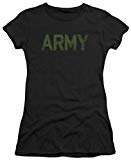

Product Title:  juniors army  type juniors slim tshirt size xl 
Euclidean Distance from input image: 16.004758239349005
Amazon Url: www.amzon.com/dp/B00XCXG24U


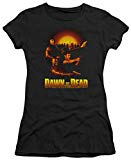

Product Title:  juniors dawn dead  dawn collage juniors slim tshirt size l 
Euclidean Distance from input image: 16.127609253170604
Amazon Url: www.amzon.com/dp/B00IAAT6AW


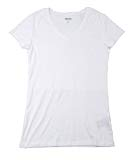

Product Title:  kirkland signature ladies size medium cotton vneck tee white 
Euclidean Distance from input image: 16.196170552692074
Amazon Url: www.amzon.com/dp/B073ZRD5FL


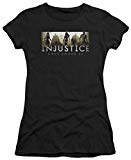

Product Title:  juniors injustice gods among us  logo juniors slim tshirt size xxl 
Euclidean Distance from input image: 16.41968158936528
Amazon Url: www.amzon.com/dp/B00IABTNOA


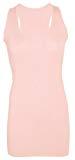

Product Title:  funky boutique womens sleeveless racer back muscle vest 810 sm nude 
Euclidean Distance from input image: 16.435775248209634
Amazon Url: www.amzon.com/dp/B00HW0HAP4


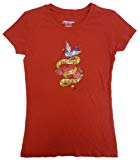

Product Title:  greensource womens born lucky tee regal red xxl 
Euclidean Distance from input image: 16.461908213538443
Amazon Url: www.amzon.com/dp/B00BGEM4QC


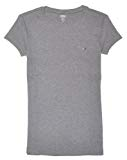

Product Title:  tommy hilfiger women slim fit crewneck logo tshirt xxl dark grey 
Euclidean Distance from input image: 16.594769541663442
Amazon Url: www.amzon.com/dp/B00B5FD7J0


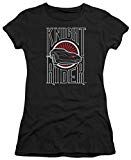

Product Title:  juniors knight rider  logo juniors slim tshirt size l 
Euclidean Distance from input image: 16.595697530110677
Amazon Url: www.amzon.com/dp/B00IABLRYO


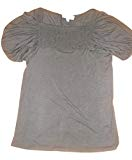

Product Title:  vivienne tam black blouse top size xs 
Euclidean Distance from input image: 16.647578979095098
Amazon Url: www.amzon.com/dp/B01EXP65XI


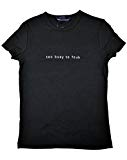

Product Title:  french connection black busy fcuk short sleeve tshirt xs xsmall 
Euclidean Distance from input image: 16.66281513722543
Amazon Url: www.amzon.com/dp/B01BUI92SG


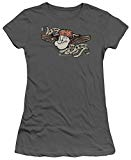

Product Title:  juniors popeye  yam juniors slim tshirt size l 
Euclidean Distance from input image: 16.70183461531253
Amazon Url: www.amzon.com/dp/B00IAAC2C6


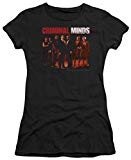

Product Title:  juniors criminal minds  crew juniors slim tshirt size 
Euclidean Distance from input image: 16.708315531653678
Amazon Url: www.amzon.com/dp/B00DEHOELW


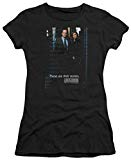

Product Title:  juniors law  order svu juniors slim tshirt size xl 
Euclidean Distance from input image: 16.72900161767256
Amazon Url: www.amzon.com/dp/B00IAAGUJC


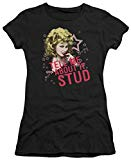

Product Title:  juniors grease  tell stud juniors slim tshirt size xxl 
Euclidean Distance from input image: 16.729239186207728
Amazon Url: www.amzon.com/dp/B00IQYQ7LS


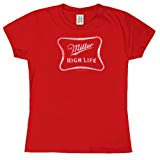

Product Title:  miller  high life juniors tshirt  large 
Euclidean Distance from input image: 16.795707702877635
Amazon Url: www.amzon.com/dp/B001GPK8G4


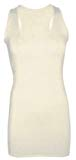

Product Title:  funky boutique womens sleeveless racer back muscle vest  810 sm cream 
Euclidean Distance from input image: 16.857247710784552
Amazon Url: www.amzon.com/dp/B00FXRN3KO


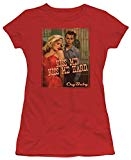

Product Title:  juniors cry baby  kiss juniors slim tshirt size xl 
Euclidean Distance from input image: 17.005444630543664
Amazon Url: www.amzon.com/dp/B00IAAF85E


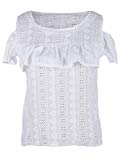

Product Title:  anna kaci sm fit classic white shoulder bare short sleeve peplum flare blouse 
Euclidean Distance from input image: 17.049812611500695
Amazon Url: www.amzon.com/dp/B010EH3B8Q


In [19]:
def recommender(doc_id,docid, w1, w2,w3, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    docid = asins.index(df_asins[docid])
    img_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[docid].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist+w3*img_dist)/float(w1 + w2+ w3)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])
    

recommender(12566,4,5, 5,5, 20)

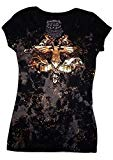

Product Title:  fifth degree womens gold foil graphic tees junior top short sleeve printed shirt  l 
Euclidean Distance from input image: 3.676990700129443
Amazon Url: www.amzon.com/dp/B01NACPBG2


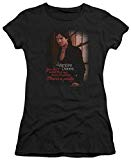

Product Title:  juniors vampire diaries  threes party juniors slim tshirt size l 
Euclidean Distance from input image: 12.393642295241767
Amazon Url: www.amzon.com/dp/B00IAAFXB8


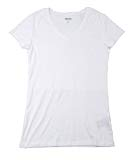

Product Title:  kirkland signature ladies size medium cotton vneck tee white 
Euclidean Distance from input image: 12.500681305112328
Amazon Url: www.amzon.com/dp/B073ZRD5FL


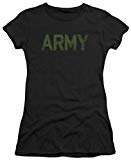

Product Title:  juniors army  type juniors slim tshirt size xl 
Euclidean Distance from input image: 12.6650065072779
Amazon Url: www.amzon.com/dp/B00XCXG24U


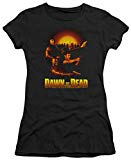

Product Title:  juniors dawn dead  dawn collage juniors slim tshirt size l 
Euclidean Distance from input image: 12.802813721064501
Amazon Url: www.amzon.com/dp/B00IAAT6AW


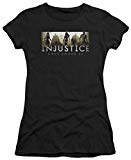

Product Title:  juniors injustice gods among us  logo juniors slim tshirt size xxl 
Euclidean Distance from input image: 12.976199019790107
Amazon Url: www.amzon.com/dp/B00IABTNOA


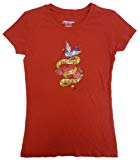

Product Title:  greensource womens born lucky tee regal red xxl 
Euclidean Distance from input image: 13.05353794134038
Amazon Url: www.amzon.com/dp/B00BGEM4QC


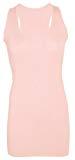

Product Title:  funky boutique womens sleeveless racer back muscle vest 810 sm nude 
Euclidean Distance from input image: 13.076831436157226
Amazon Url: www.amzon.com/dp/B00HW0HAP4


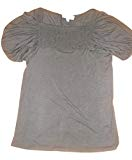

Product Title:  vivienne tam black blouse top size xs 
Euclidean Distance from input image: 13.14712206208747
Amazon Url: www.amzon.com/dp/B01EXP65XI


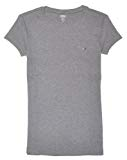

Product Title:  tommy hilfiger women slim fit crewneck logo tshirt xxl dark grey 
Euclidean Distance from input image: 13.15318393743413
Amazon Url: www.amzon.com/dp/B00B5FD7J0


In [20]:
recommender(12566,4,5,10,5,10)

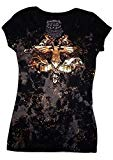

Product Title:  fifth degree womens gold foil graphic tees junior top short sleeve printed shirt  l 
Euclidean Distance from input image: 5.232661056699243
Amazon Url: www.amzon.com/dp/B01NACPBG2


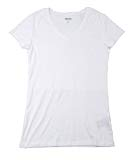

Product Title:  kirkland signature ladies size medium cotton vneck tee white 
Euclidean Distance from input image: 13.163100051970227
Amazon Url: www.amzon.com/dp/B073ZRD5FL


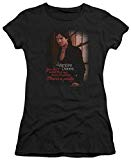

Product Title:  juniors vampire diaries  threes party juniors slim tshirt size l 
Euclidean Distance from input image: 13.740757209480014
Amazon Url: www.amzon.com/dp/B00IAAFXB8


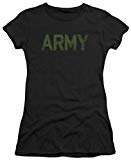

Product Title:  juniors army  type juniors slim tshirt size xl 
Euclidean Distance from input image: 13.969899970710483
Amazon Url: www.amzon.com/dp/B00XCXG24U


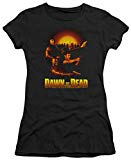

Product Title:  juniors dawn dead  dawn collage juniors slim tshirt size l 
Euclidean Distance from input image: 13.992352295102563
Amazon Url: www.amzon.com/dp/B00IAAT6AW


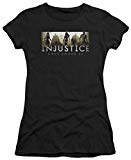

Product Title:  juniors injustice gods among us  logo juniors slim tshirt size xxl 
Euclidean Distance from input image: 14.251135093391147
Amazon Url: www.amzon.com/dp/B00IABTNOA


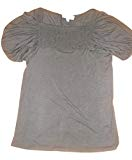

Product Title:  vivienne tam black blouse top size xs 
Euclidean Distance from input image: 14.321068793952671
Amazon Url: www.amzon.com/dp/B01EXP65XI


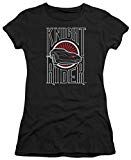

Product Title:  juniors knight rider  logo juniors slim tshirt size l 
Euclidean Distance from input image: 14.342306518554688
Amazon Url: www.amzon.com/dp/B00IABLRYO


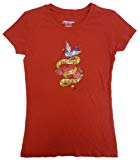

Product Title:  greensource womens born lucky tee regal red xxl 
Euclidean Distance from input image: 14.370608902158228
Amazon Url: www.amzon.com/dp/B00BGEM4QC


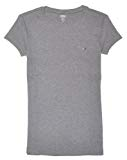

Product Title:  tommy hilfiger women slim fit crewneck logo tshirt xxl dark grey 
Euclidean Distance from input image: 14.395015335263697
Amazon Url: www.amzon.com/dp/B00B5FD7J0


In [22]:
recommender(12566,4,10,5,5,10)

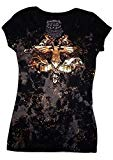

Product Title:  fifth degree womens gold foil graphic tees junior top short sleeve printed shirt  l 
Euclidean Distance from input image: 3.9598452252571934
Amazon Url: www.amzon.com/dp/B01NACPBG2


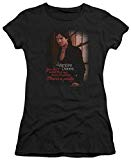

Product Title:  juniors vampire diaries  threes party juniors slim tshirt size l 
Euclidean Distance from input image: 15.642939289967494
Amazon Url: www.amzon.com/dp/B00IAAFXB8


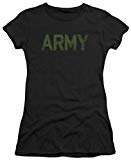

Product Title:  juniors army  type juniors slim tshirt size xl 
Euclidean Distance from input image: 16.004758239349005
Amazon Url: www.amzon.com/dp/B00XCXG24U


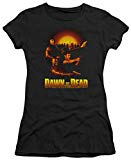

Product Title:  juniors dawn dead  dawn collage juniors slim tshirt size l 
Euclidean Distance from input image: 16.127609253170604
Amazon Url: www.amzon.com/dp/B00IAAT6AW


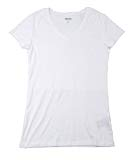

Product Title:  kirkland signature ladies size medium cotton vneck tee white 
Euclidean Distance from input image: 16.196170552692074
Amazon Url: www.amzon.com/dp/B073ZRD5FL


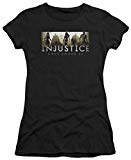

Product Title:  juniors injustice gods among us  logo juniors slim tshirt size xxl 
Euclidean Distance from input image: 16.41968158936528
Amazon Url: www.amzon.com/dp/B00IABTNOA


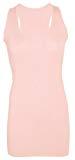

Product Title:  funky boutique womens sleeveless racer back muscle vest 810 sm nude 
Euclidean Distance from input image: 16.435775248209634
Amazon Url: www.amzon.com/dp/B00HW0HAP4


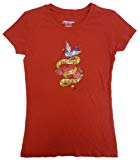

Product Title:  greensource womens born lucky tee regal red xxl 
Euclidean Distance from input image: 16.461908213538443
Amazon Url: www.amzon.com/dp/B00BGEM4QC


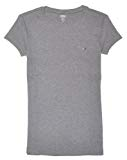

Product Title:  tommy hilfiger women slim fit crewneck logo tshirt xxl dark grey 
Euclidean Distance from input image: 16.594769541663442
Amazon Url: www.amzon.com/dp/B00B5FD7J0


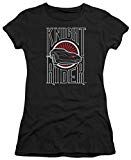

Product Title:  juniors knight rider  logo juniors slim tshirt size l 
Euclidean Distance from input image: 16.595697530110677
Amazon Url: www.amzon.com/dp/B00IABLRYO


In [23]:
recommender(12566,4,10,10,10,10)